# RFM analysis: Periodic Flux between customers segments.
---
Murilo Henrique Gomes

In this analysis our focus will be the transition that a customer can make between the segments. The purpose of this study is offer business inteligence for the client and make more understamble how their customers behavoir is associate with the volume and frequency of shopes in each month.

## Bibliotecas e funções:

### Imports:

In [ ]:
import IPython

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime

In [ ]:
!pip install chart_studio
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


### Scripts:

In [ ]:

def RecencyClassification(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 2
    else:
        return 1

def FrequencyMonetaryClassification(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5

## Data Acess:

In [ ]:
raw_data = pd.read_csv('path')
raw_data['date'] = pd.to_datetime(raw_data['trans_date'], infer_datetime_format = True)
raw_data['months'] = pd.Series([x.month for x in raw_data['date']])

raw_segmen = pd.read_csv('path')

In [ ]:
raw_data.head(3)

,customer_id,trans_date,tran_amount,date,months
0,CS5295,11-Feb-13,35,2013-02-11,2
1,CS4768,15-Mar-15,39,2015-03-15,3
2,CS2122,26-Feb-13,52,2013-02-26,2


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  object        
 2   tran_amount  125000 non-null  int64         
 3   date         125000 non-null  datetime64[ns]
 4   months       125000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 4.8+ MB


In [ ]:
print('The observed total period begin in', raw_data['date'].min().date(), 'and finishes at', raw_data['date'].max().date())

The observed total period begin in 2011-05-16 and finishes at 2015-03-16


In [ ]:
raw_segmen.head(3)

,customer_id,recency,frequency,monetary value,RecencyScore,FrequencyScore,MonetaryScore,FrequencyMonetaryScore,axis,Segmento
0,CS1112,62.0,15,1012,3,2,2,2.0,1,Hibernando
1,CS1113,36.0,20,1490,4,4,4,4.0,1,Campeões
2,CS1114,33.0,19,1432,4,3,4,3.5,1,Perdidos


## Analysis of flux between segments of clients:

### Define the observed period:


We will take the last 15 month as the data window. This choice is motivated by the duration of 5 years of the datebase, so most of the customers are segmented as 'Perdidos' (aka Lost), because the last shope has a long distance compared to the day after the last, our reference to the recency metric.

In [ ]:
period = datetime.timedelta(weeks = 15*4)

first_day_observed = raw_data['date'].max() - period

print(first_day_observed.date())

2014-01-20


In [ ]:
observed_data = raw_data.loc[raw_data['date'] >= first_day_observed]
observed_data = observed_data.sort_values('date')
observed_data.head(3)

,customer_id,trans_date,tran_amount,date,months
8612,CS3810,20-Jan-14,101,2014-01-20,1
92644,CS4603,20-Jan-14,47,2014-01-20,1
56847,CS2492,20-Jan-14,44,2014-01-20,1


These observed data values must be splited in 4 parts:


1.   The first 12 month (year);
2.   The next 1 month (year + 1 month);
3.   The next 1 month (year + 2 month);
4.   The next 1 month (year + 3 month).



In [ ]:
delta_2 = datetime.timedelta(weeks = 1*4)
delta_1 = datetime.timedelta(weeks = 2*4)
delta_0 = datetime.timedelta(weeks = 3*4)

observed_0 =  observed_data.loc[observed_data['date'] < (raw_data['date'].max() - delta_0)]
observed_1 =  observed_data.loc[(observed_data['date'] < (raw_data['date'].max() - delta_1) ) & (observed_data['date'] >= (raw_data['date'].max() - delta_0))]
observed_2 =  observed_data.loc[(observed_data['date'] < (raw_data['date'].max() - delta_2)) & (observed_data['date'] >= (raw_data['date'].max() - delta_1))]
observed_3 =  observed_data.loc[observed_data['date'] >= (raw_data['date'].max() - delta_2)]

In [ ]:
# Check if these conditons returned the desire periods:
print('The observed_0 total period begin in', observed_0['date'].min().date(), 'and finishes at', observed_0['date'].max().date())
print('The observed_1 total period begin in', observed_1['date'].min().date(), 'and finishes at', observed_1['date'].max().date())
print('The observed_2 total period begin in', observed_2['date'].min().date(), 'and finishes at', observed_2['date'].max().date())
print('The observed_3 total period begin in', observed_3['date'].min().date(), 'and finishes at', observed_3['date'].max().date())

The observed_0 total period begin in 2014-01-20 and finishes at 2014-12-21
The observed_1 total period begin in 2014-12-22 and finishes at 2015-01-18
The observed_2 total period begin in 2015-01-19 and finishes at 2015-02-15
The observed_3 total period begin in 2015-02-16 and finishes at 2015-03-16


### Applying segmentation:

Start from the first 12 months of the observed data, we will segment the customers and then mapping in a distance matrix how many moved from one segment to another.

Apart from that, we will create a class column named 'new' customers, aka, customers that maked their first shope in the observed period. So, we can analysis for what segment them moved.

In [ ]:
last_day = observed_0['date'].max() + datetime.timedelta(days=1)

observed_0['diff'] = last_day - observed_0['date']
observed_0['diff'] = observed_0['diff'].astype('timedelta64[D]')

observed_0.head()

<ipython-input-20-79e217f848c9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-79e217f848c9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,customer_id,trans_date,tran_amount,date,months,diff
8612,CS3810,20-Jan-14,101,2014-01-20,1,336.0
92644,CS4603,20-Jan-14,47,2014-01-20,1,336.0
56847,CS2492,20-Jan-14,44,2014-01-20,1,336.0
52240,CS5702,20-Jan-14,41,2014-01-20,1,336.0
4482,CS1498,20-Jan-14,47,2014-01-20,1,336.0


In [ ]:
rfm_0 = observed_0.groupby('customer_id').agg({'diff': lambda x:x.min(),
                                        'customer_id': lambda x: len(x),
                                        'tran_amount': lambda x: x.sum()})
rfm_0 = rfm_0.rename(columns= {'diff': 'recency', 'customer_id': 'frequency',
                           'tran_amount': 'monetary value'})
rfm_0['new']= np.where(rfm_0['frequency']!= 1, 0, 1)

In [ ]:
quintiles = rfm_0.quantile(q=[0.20,0.40,0.60,0.80])
quintiles=quintiles.to_dict()

In [ ]:
rfmSegmen_0 = rfm_0
rfmSegmen_0['RecencyScore'] = rfmSegmen_0['recency'].apply(RecencyClassification, args=('recency',quintiles))
rfmSegmen_0['FrequencyScore'] = rfmSegmen_0['frequency'].apply(FrequencyMonetaryClassification, args=('frequency',quintiles))
rfmSegmen_0['MonetaryScore'] = rfmSegmen_0['monetary value'].apply(FrequencyMonetaryClassification, args=('monetary value',quintiles))

In [ ]:
# FM Score
rfmSegmen_0 = rfmSegmen_0.assign(FrequencyMonetaryScore = lambda x: (x.FrequencyScore + x.MonetaryScore)/2, axis = 1)

# Segmentos
segmentos =  ['Novos', 'Campeões', 'Fieis','Promissores', 'Não Perder', 'Hibernando', 'Perdidos']

# Aplicando Segmentação

conditions = [
    (rfmSegmen_0['new'] == 1 ),
    ((rfmSegmen_0['RecencyScore'].between(4, 5, inclusive = 'both')) & (rfmSegmen_0['FrequencyMonetaryScore'].between(4, 5, inclusive = 'both'))), # Campeões
    ((rfmSegmen_0['RecencyScore'] == 3) & (rfmSegmen_0['FrequencyMonetaryScore'].between(3, 3.99, inclusive = 'both'))), # Fieis
    ((rfmSegmen_0['RecencyScore'].between(4, 5, inclusive = 'both')) & (rfmSegmen_0['FrequencyMonetaryScore'].between(1, 2.99, inclusive = 'both'))), # Promissor
    ((rfmSegmen_0['RecencyScore'].between(1, 2.99, inclusive = 'both')) & (rfmSegmen_0['FrequencyMonetaryScore'].between(4, 5, inclusive = 'both'))), # Perdendo alto tkt médio
    (((rfmSegmen_0['RecencyScore'] == 3) & (rfmSegmen_0['FrequencyMonetaryScore'].between(1, 2.99, inclusive = 'both')) ) | ( (rfmSegmen_0['RecencyScore'] == 2) & (rfmSegmen_0['FrequencyMonetaryScore'].between(2, 3.99, inclusive = 'both')) ) ), # Hibernando
    ((rfmSegmen_0['RecencyScore'] == 1) & (rfmSegmen_0['FrequencyMonetaryScore'].between(1, 3.99, inclusive = 'both')))# Perdidos
]

choices = segmentos
rfmSegmen_0['Segmento'] = np.select(conditions, choices, default = 'Perdidos')

print('-----------------------------------')
print('Número de clientes para cada segmento')
print(rfmSegmen_0['Segmento'].value_counts())

-----------------------------------
Número de clientes para cada segmento
Perdidos       2329
Hibernando     1231
Campeões       1071
Promissores    1039
Novos           419
Não Perder      395
Fieis           284
Name: Segmento, dtype: int64


May be is interesting encapsulate this code of segmentation, but this is a after work.

### Mapping the change of segment class for each customer:

Foremost we need the next segmentation, that will occurs mergin the frist 12 month with the next month.

In [ ]:
frames = [observed_0, observed_1]
observed_next_1 = pd.concat(frames).drop(columns =['diff'])
observed_next_1

,customer_id,trans_date,tran_amount,date,months
8612,CS3810,20-Jan-14,101,2014-01-20,1
92644,CS4603,20-Jan-14,47,2014-01-20,1
56847,CS2492,20-Jan-14,44,2014-01-20,1
52240,CS5702,20-Jan-14,41,2014-01-20,1
4482,CS1498,20-Jan-14,47,2014-01-20,1
...,...,...,...,...,...
60039,CS3039,18-Jan-15,84,2015-01-18,1
70882,CS4916,18-Jan-15,50,2015-01-18,1
32688,CS3008,18-Jan-15,37,2015-01-18,1
100504,CS7982,18-Jan-15,28,2015-01-18,1


To check if this process is right, is enough check the beginning and the end of the this observed period.

In [ ]:
print('The observed_next_1 total period begin in', observed_next_1['date'].min().date(), 'and finishes at', observed_next_1['date'].max().date())

The observed_next_1 total period begin in 2014-01-20 and finishes at 2015-01-18


In [ ]:
last_day = observed_next_1['date'].max() + datetime.timedelta(days=1)

observed_next_1['diff'] = last_day - observed_next_1['date']
observed_next_1['diff'] = observed_next_1['diff'].astype('timedelta64[D]')

observed_next_1.head()

,customer_id,trans_date,tran_amount,date,months,diff
8612,CS3810,20-Jan-14,101,2014-01-20,1,364.0
92644,CS4603,20-Jan-14,47,2014-01-20,1,364.0
56847,CS2492,20-Jan-14,44,2014-01-20,1,364.0
52240,CS5702,20-Jan-14,41,2014-01-20,1,364.0
4482,CS1498,20-Jan-14,47,2014-01-20,1,364.0


In [ ]:
rfm_1 = observed_next_1.groupby('customer_id').agg({'diff': lambda x:x.min(),
                                        'customer_id': lambda x: len(x),
                                        'tran_amount': lambda x: x.sum()})
rfm_1 = rfm_1.rename(columns= {'diff': 'recency', 'customer_id': 'frequency',
                           'tran_amount': 'monetary value'})
rfm_1['new']= np.where(rfm_1['frequency']!= 1, 0, 1)

In [ ]:
rfm_1

,recency,frequency,monetary value,new
customer_id,,,,
CS1112,5.0,4,251,0
CS1113,5.0,4,217,0
CS1114,19.0,6,425,0
CS1115,215.0,3,243,0
CS1116,147.0,5,333,0
...,...,...,...,...
CS8996,41.0,6,336,0
CS8997,205.0,2,84,0
CS8998,28.0,4,130,0


In [ ]:
quintiles = rfm_1.quantile(q=[0.20,0.40,0.60,0.80])
quintiles=quintiles.to_dict()

rfmSegmen_1 = rfm_1
rfmSegmen_1['RecencyScore'] = rfmSegmen_1['recency'].apply(RecencyClassification, args=('recency',quintiles))
rfmSegmen_1['FrequencyScore'] = rfmSegmen_1['frequency'].apply(FrequencyMonetaryClassification, args=('frequency',quintiles))
rfmSegmen_1['MonetaryScore'] = rfmSegmen_1['monetary value'].apply(FrequencyMonetaryClassification, args=('monetary value',quintiles))

In [ ]:
# FM Score
rfmSegmen_1 = rfmSegmen_1.assign(FrequencyMonetaryScore = lambda x: (x.FrequencyScore + x.MonetaryScore)/2, axis = 1)

# Segmentos
segmentos =  ['Novos', 'Campeões', 'Fieis','Promissores', 'Não Perder', 'Hibernando', 'Perdidos']

# Aplicando Segmentação

conditions = [
    (rfmSegmen_1['new'] ==1 ),
    ((rfmSegmen_1['RecencyScore'].between(4, 5, inclusive = 'both')) & (rfmSegmen_1['FrequencyMonetaryScore'].between(4, 5, inclusive = 'both'))), # Campeões
    ((rfmSegmen_1['RecencyScore'] == 3) & (rfmSegmen_1['FrequencyMonetaryScore'].between(3, 3.99, inclusive = 'both'))), # Fieis
    ((rfmSegmen_1['RecencyScore'].between(4, 5, inclusive = 'both')) & (rfmSegmen_1['FrequencyMonetaryScore'].between(1, 2.99, inclusive = 'both'))), # Promissor
    ((rfmSegmen_1['RecencyScore'].between(1, 2.99, inclusive = 'both')) & (rfmSegmen_1['FrequencyMonetaryScore'].between(4, 5, inclusive = 'both'))), # Perdendo alto tkt médio
    (((rfmSegmen_1['RecencyScore'] == 3) & (rfmSegmen_1['FrequencyMonetaryScore'].between(1, 2.99, inclusive = 'both')) ) | ( (rfmSegmen_1['RecencyScore'] == 2) & (rfmSegmen_1['FrequencyMonetaryScore'].between(2, 3.99, inclusive = 'both')) ) ), # Hibernando
    ((rfmSegmen_1['RecencyScore'] == 1) & (rfmSegmen_1['FrequencyMonetaryScore'].between(1, 3.99, inclusive = 'both')))# Perdidos
]

choices = segmentos
rfmSegmen_1['Segmento'] = np.select(conditions, choices, default = 'Perdidos')

print('-----------------------------------')
print('Número de clientes para cada segmento')
print(rfmSegmen_1['Segmento'].value_counts())

-----------------------------------
Número de clientes para cada segmento
Perdidos       2408
Campeões       1194
Hibernando     1154
Promissores     985
Não Perder      481
Novos           309
Fieis           264
Name: Segmento, dtype: int64


In [ ]:
rfmSegmen_0

,recency,frequency,monetary value,new,RecencyScore,FrequencyScore,MonetaryScore,FrequencyMonetaryScore,axis,Segmento
customer_id,,,,,,,,,,
CS1112,18.0,3,212,0,5,1,2,1.5,1,Promissores
CS1113,146.0,3,173,0,1,1,2,1.5,1,Perdidos
CS1114,10.0,5,330,0,5,3,4,3.5,1,Perdidos
CS1115,187.0,3,243,0,1,1,3,2.0,1,Perdidos
CS1116,119.0,5,333,0,2,3,4,3.5,1,Hibernando
...,...,...,...,...,...,...,...,...,...,...
CS8996,13.0,6,336,0,5,4,4,4.0,1,Campeões
CS8997,177.0,2,84,0,1,1,1,1.0,1,Perdidos
CS8998,61.0,3,81,0,3,1,1,1.0,1,Hibernando


In [ ]:
rfmSegmen_1

,recency,frequency,monetary value,new,RecencyScore,FrequencyScore,MonetaryScore,FrequencyMonetaryScore,axis,Segmento
customer_id,,,,,,,,,,
CS1112,5.0,4,251,0,5,2,3,2.5,1,Promissores
CS1113,5.0,4,217,0,5,2,2,2.0,1,Promissores
CS1114,19.0,6,425,0,4,4,4,4.0,1,Campeões
CS1115,215.0,3,243,0,1,1,3,2.0,1,Perdidos
CS1116,147.0,5,333,0,1,3,3,3.0,1,Perdidos
...,...,...,...,...,...,...,...,...,...,...
CS8996,41.0,6,336,0,3,4,3,3.5,1,Fieis
CS8997,205.0,2,84,0,1,1,1,1.0,1,Perdidos
CS8998,28.0,4,130,0,4,2,1,1.5,1,Promissores


In [ ]:
import itertools
#list(itertools.product(segmentos, segmentos))


In [ ]:
rfm_a = rfmSegmen_0.reset_index()[['customer_id','Segmento']].rename(columns = {'Segmento': 'Segmento_A'})
rfm_b = rfmSegmen_1.reset_index()[['customer_id','Segmento']].rename(columns = {'Segmento': 'Segmento_B'})

rfm_a = rfm_a.drop(columns = ['customer_id'])

rfm_x = pd.concat([rfm_a, rfm_b], axis = 1)
rfm_x

,Segmento_A,customer_id,Segmento_B
0,Promissores,CS1112,Promissores
1,Perdidos,CS1113,Promissores
2,Perdidos,CS1114,Campeões
3,Perdidos,CS1115,Perdidos
4,Hibernando,CS1116,Perdidos
...,...,...,...
6790,NaN,CS8996,Fieis
6791,NaN,CS8997,Perdidos
6792,NaN,CS8998,Promissores
6793,NaN,CS8999,Perdidos


NaN in A's customer_id and Segmento columns is caused by the fact that this customers don't appears any time in the frist 12 months, but made more than a shope in the period B.

So, to contour this problem we will name this customers as 'novos' to continuate this work. Another way of deal, is exclude all rows with NaN values, this will be try for comparassion purpose.

In [ ]:
rfm_x['Segmento_A'] = rfm_x.Segmento_A.fillna('Novos')
rfm_x['count'] = 1
rfm_x = rfm_x.groupby(['Segmento_A', 'Segmento_B']).sum()

<ipython-input-36-4e278d8a8fc6>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
rfm_x

count
Segmento_A  Segmento_B        
Campeões    Campeões       281
            Fieis           50
            Hibernando     141
            Novos           30
            Não Perder      89
            Perdidos       367
            Promissores    113
Fieis       Campeões        56
            Fieis           17
            Hibernando      61
            Novos            8
            Não Perder      23
            Perdidos        95
            Promissores     24
Hibernando  Campeões       185
            Fieis           44
            Hibernando     246
            Novos           57
            Não Perder      69
            Perdidos       460
            Promissores    170
Novos       Campeões        43
            Fieis           11
            Hibernando      87
            Novos           32
            Não Perder      18
            Perdidos       154
            Promissores    101
Não Perder  Campeões        97
            Fieis            9
            Hibernando      49
            Novos           11
            Não Perder      76
            Perdidos       114
            Promissores     39
Perdidos    Campeões       390
            Fieis           96
            Hibernando     355
            Novos          117
            Não Perder     152
            Perdidos       867
            Promissores    352
Promissores Campeões       142
            Fieis           37
            Hibernando     215
            Novos           54
            Não Perder      54
            Perdidos       351
            Promissores    186

In [ ]:
rfm_x.to_csv('/content/gdrive/MyDrive/Bases de Dados/RFM/ExampleTransition.csv')

In [ ]:
df_2 = rfm_x.reset_index().rename(columns={"Segmento_A": "source", "Segmento_B": "target", 'count': 'weight'})

In [ ]:
df_2

,source,target,weight
0,Campeões,Campeões,281
1,Campeões,Fieis,50
2,Campeões,Hibernando,141
3,Campeões,Novos,30
4,Campeões,Não Perder,89
5,Campeões,Perdidos,367
6,Campeões,Promissores,113
7,Fieis,Campeões,56
8,Fieis,Fieis,17
9,Fieis,Hibernando,61


In [ ]:
node_data = pd.DataFrame(np.array(segmentos), columns = ['nodes'])
node_data

,nodes
0,Novos
1,Campeões
2,Fieis
3,Promissores
4,Não Perder
5,Hibernando
6,Perdidos


In [ ]:
df_2['source'] = df_2['source'].replace({'Novos': 0, 'Campeões':1, 'Fieis': 2, 'Promissores': 3, 'Não Perder': 4, 'Hibernando':5, 'Perdidos': 6}, regex = True)
df_2['target'] = df_2['target'].replace({'Novos': 0, 'Campeões':1, 'Fieis': 2, 'Promissores': 3, 'Não Perder': 4, 'Hibernando':5, 'Perdidos': 6}, regex = True)
df_2

,source,target,weight
0,1,1,281
1,1,2,50
2,1,5,141
3,1,0,30
4,1,4,89
5,1,6,367
6,1,3,113
7,2,1,56
8,2,2,17
9,2,5,61


## Visualizing the flux between each class

In [ ]:
!pip install holoviews

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
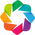

:Chord   [source,target]   (weight)

In [ ]:
import holoviews as hv
from holoviews import opts, dim
import holoviews.plotting.bokeh
hv.extension('bokeh')
hv.output(size=200)
#add node labels
nodes = hv.Dataset(pd.DataFrame(node_data['nodes']), 'index')
#create chord object
chord = hv.Chord((df_2, nodes)).select(value=(5, None))
#customization of chart
chord.opts(
           opts.Chord(cmap='Category20', edge_cmap='Category20',edge_color=dim('source').str(),
           labels='nodes', node_color=dim('index').str()))